# EEG Classification of Emotions Using CNN, SAE, and DNN

From the paper "EEG-Based Emotion Classification Using a Deep Neural Network and Sparse Autoencoder", they found to have incredibly high recognition accuracy for emotions using EEG data that they put through a Convolutional Recurrent Neural Network, then a Sparse Autoencoder, and finally a Deep Neural Network.

Paper: https://www.frontiersin.org/articles/10.3389/fnsys.2020.00043/full

DEAP Dataset: https://www.eecs.qmul.ac.uk/mmv/datasets/deap/

## Import Libraries

In [1]:
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import os

## Load Data

- 32 subjects
- 40 sets of 63 second recordings (first 3 seconds are buffer)
- 512 Hz recording
- 32 EEG Channels
- (30 * 40) 1280 recordings 32 * (512 * 63) 32256 matrixes
- Valence and Arousal are recorded for all 40 trials of each subject

Input Matrix Shape: `1280 x 32 x 32256`

Output Matrix Shape: `1280 x 2`

In [6]:
RECORDINGS_PATH = "../../../TestData/Recordings/S1"
ext = ('.md.csv')

EEG_COLUMNS = ["EEG.Counter", "EEG.AF3", "EEG.F7", "EEG.F3", "EEG.FC5", "EEG.T7", "EEG.P7", "EEG.O1", "EEG.O2", "EEG.P8", "EEG.T8", "EEG.FC6", "EEG.F4", "EEG.F8", "EEG.AF4"]

for files in os.listdir(RECORDINGS_PATH):
    if files.endswith(ext):
        df = pd.read_csv(RECORDINGS_PATH + "/" + files)
        print(df.head(5))
    else:
        continue

15
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        title:happy  \
Timestamp         OriginalTimestamp EEG.Counter EEG.Interpolated EEG.AF3     EEG.F7      EEG.F3      EEG.FC5     EEG.T7      EEG.P7      EEG.O1      EEG.O2      EEG.P8      EEG.T8      EEG.FC6     EEG.F4      EEG.F8      EEG.AF4     EEG.RawCq   EEG.Battery EEG.BatteryPercent MarkerIndex MarkerType MarkerValueInt EEG.MarkerHardware CQ.AF3   CQ.F7    CQ.F3    CQ.FC5

## Remove Buffer Time

- Remove the first 3 seconds of time from each epoch. We will not be normalizing.
- (512 * 63) => (512 x 60)
- 32256 => 30720

Input Matrix Shape: `1280 x 32 x 30720`

## Decimate Data

- Move from 512 Hz to 128 Hz
- (512 * 60) => (128 * 60)
- 30720 => 7680

Input Matrix Shape: `1280 x 32 x 7680`

## General Band-Pass Filter

- This is used to get rid of general noise
- Done across the Hz range 0.1-50

Input Matrix Shape: `1280 x 32 x 7680`

## Butterworth Band-Pass Filter

- $\alpha$ (1-7 Hz), $\beta$ (8-13 Hz), $\theta$ (14-30 Hz), $\lambda$ (30-45 Hz)
- This will break up the single stream of data from each channel into 4 streams of separate bands

Input Matrix Shape: `1280 x 4 x 32 x 7680`

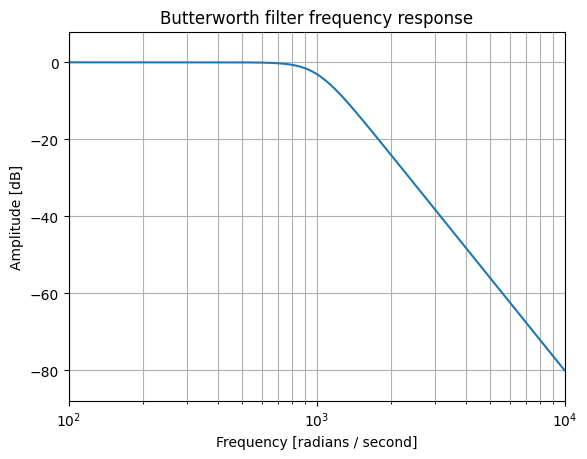

In [2]:
# Design an analog filter and plot its frequency response, showing the crticial points
b, a = signal.butter(4, 1000, 'low', analog=True)
w, h = signal.freqs(b, a)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green') # cutoff frequency
plt.show()

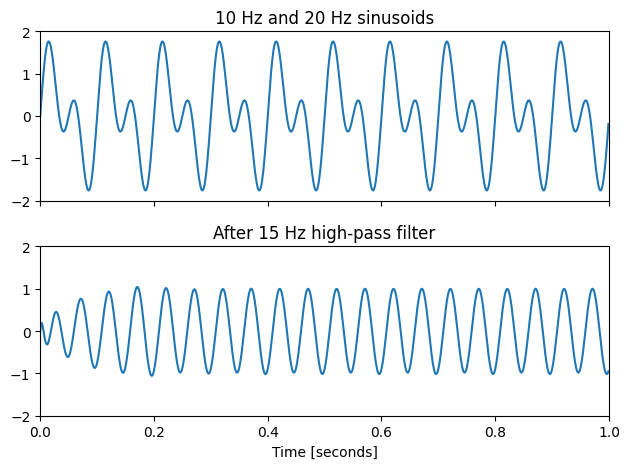

In [5]:
# Generate a signal made up of 10 Hz and 20 Hz, sampled at 1 kHz
t = np.linspace(0, 1, 1000, False) # 1 second
sig = np.sin(2*np.pi*10*t) + np.sin(2*np.pi*20*t)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(t, sig)
ax1.set_title('10 Hz and 20 Hz sinusoids')
ax1.axis([0, 1, -2, 2])
# Design a digital high-pass filter at 15Hz to remove the 10 Hz tone, and apply it to the signal.
# (It's recommended to use second-order sections format when filtering, to avoid numerical error with
# transfer function (ba) format):
sos = signal.butter(10, 15, 'hp', fs=1000, output='sos')
filtered = signal.sosfilt(sos, sig)
ax2.plot(t, filtered)
ax2.set_title('After 15 Hz high-pass filter')
ax2.axis([0, 1, -2, 2])
ax2.set_xlabel('Time [seconds]')
plt.tight_layout()
plt.show()

## Epoch the Epochs

- For each trils of 60 s, 14 segments are obtained using an 8 s time window moving every 4 s.
- This will extrapolate our training data
- (128 * 60) => (128 * 8)
- 7680 => 1024
- 1280 * 14 = 17920
- Increasing our input data means we increase output
- All 14 new samples from each apoch have the same output

Input Matrix Shape: `17920 x 4 x 32 x 1024`

Output Matrix Shape: `17920 x 2`

## PCC Feature Extraction

- PCC (Pearson Correlation Coefficient)
- On every band and epoch
- Basically calculating correlation of every channel pair against each other
- (32 x 1024) => (32 x 32)

Input Matrix Shape: `17920 x 4 x 32 x 32`

## Split Training and Testing Set

- 80% Training, 20% Testing

Training Input Matrix Shape: `14336 x 4 x 32 x 32`

Training Output Matrix Shape: `14336 x 2`

Testing Input Matrix Shape: `3584 x 4 x 32 x 32`

Testing Output Matrix Shape: `3584 x 2`

## Develop Convolutional Neural Network (CNN)

- Input Convolutional Layer
    - Input Size: Four 32 x 32 "images" (4 bands PCC matrix)
    - Kernel Size = 3 x 1
    - \# of Kernels = 32
- Hidden Convolutional Layer
    - Kernel Size = 3 x 1
    - \# of Kernels = 32
- Dropout Layer
- Hidden Max-Pooling Layer
    - Pooling Size = 3 x 3
    - \# of Kernels = 64
- Dropout Layer
- Staging Layer
    - Shape: 64 x 10 x 9
- Output Layer
    - (Valence, Arousal) tuple

## Train CNN

- Training Epochs = 50
- Batch Size = 128
- Learning Rate = 0.01

## After Training, Drop Output Layer

- This makes the Staging Layer the new Output Layer
- Run Training Input Matrix through CNN an get the output.
- **Note:** Just using a CNN for classification is known to not have the best results. This is the main idea of the paper. We initially have a 2-neuron output layer for training in order for back propagation in the CNN to adjust the weights, but then dorp the output layer and take the data in the staging layer, flatten it, and put it into the SAE

Training Input Matrix Size: `14336 x 64 x 10 x 9`

## Flatten 3D Output From CNN into 1D Vector

- Data needs to be one-dimensional to go into SAE

Training Input Matrix Size: `14336 x 5760`

## Develop Sparse Autoencoder (SAE)

- Input Layer: 5760 Nodes
- Encoder Layer: 512 Nodes
- Hidden Layer: 128 Nodes
- Output Decoder Layer: 512 Nodes

## Train SAE

- SAE's are unsupervised learning models so we don't train it against an expected output.
- Training Epochs = 100
- Batch Size = 64
- Learning Rate = 0.01

## Get SAE Output

- Using the flattened output from the CNN as input to the trained SAE, get the output to use as training data for DNN

Training Input Matrix Shape: `14336 x 512`

## Develop Deep Neural Network (DNN)

- Fully Connected Input Layer: 512 Nodes
- Fully Connected Hidden Layer: 256 Nodes
- Fully Connected Output Layer: 2 Nodes ((Valence, Arousal) tuple)

## Train DNN

- Use the output of the trained SAE as training input for the DNN. The expected outputs to the DNN are teh original (V,A) tuple.
- Training Epochs = 100
- Batch Size = 128
- Learning Rate = 0.01

## Analyze Full Model with Testing Set

- `3584 x 4 x 32 x 32` ==CNN==> ==SAE==> ==DNN==> `3584 x 2`